# Structural balance theory (SBT), part I

Here we will try to build a basic understanding of so-called 
*Structural Balance Theory* (SBT), which is one of the oldest network science theories
and deals with systems involving antagonistic relationships, which can be represented
as *signed networks*.

We will use this opportunity also as a case study in how network theories are built
and operationalized based on first principles. Of course, we will have to simplify
or skip quite a few details but in spite of that we will still get some valuable
insight into the practice of theory building.

**NOTE.**

We will use `igraph` as our main software for graph-theoretic computations.
Check [documentation](https://python.igraph.org/en/stable/) for a review
of its functionalities.

In [2]:
# Load libraries
# !pip install "numpy" "scipy" "matplotlib" "python-igraph>=0.10.4" "tqdm"
import random
import numpy as np
import scipy as sp
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt

# IGraph configuration
# Set configuration variables
ig.config["plotting.backend"] = "matplotlib"  # use Matplotlib as plotting backend
ig.config["plotting.vertex_color"] = "white"
ig.config["plotting.vertex_size"] = "20"
ig.config["plotting.edge_alpha"] = "10"

# Set random seed for IGRAPH and setup a random generator for Numpy
random.seed(101)
RNG = np.random.default_rng(101)

# Predefine some colors
RED  = "#D81F29"
BLUE = "#3E7AFC"
GRAY = "#BEBEBE"

# THIS IS A UTILITY FUNCTION WE WILL USE
# Technical details are outside the scope of this notebok.
def signed_embedding(A, k =2, beta=1, attr="weight"):
    if isinstance(A, ig.Graph):
        A = A.get_adjacency_sparse(attribute=attr).todense()
    A = (A + A.T) / 2
    C = sp.linalg.expm(beta*A)
    D = np.diag(1 / np.sqrt(C.diagonal()))
    L, V = np.linalg.eigh(D@C@D)
    L = L[-k:]
    V = V[:, -k:]
    Z = V*np.sqrt(L)
    return Z

def get_edge_colors(G, pos=BLUE, neg=RED, attr="weight"):
    return np.where(np.array(G.es["weight"]) < 0, neg, pos)

## Signed networks, SBT and polarization

Before moving forward let us first define and visualize two very different signed
networks:

1. With positive/negative connections being completely random.
2. With two groups with exclusively positive in-group and negative out-group ties.

Note that the second case has a mesoscopic structure which can be considered polarized.
On the other hand, in the first case there is not much structure to how 
positive/negative ties are organized.

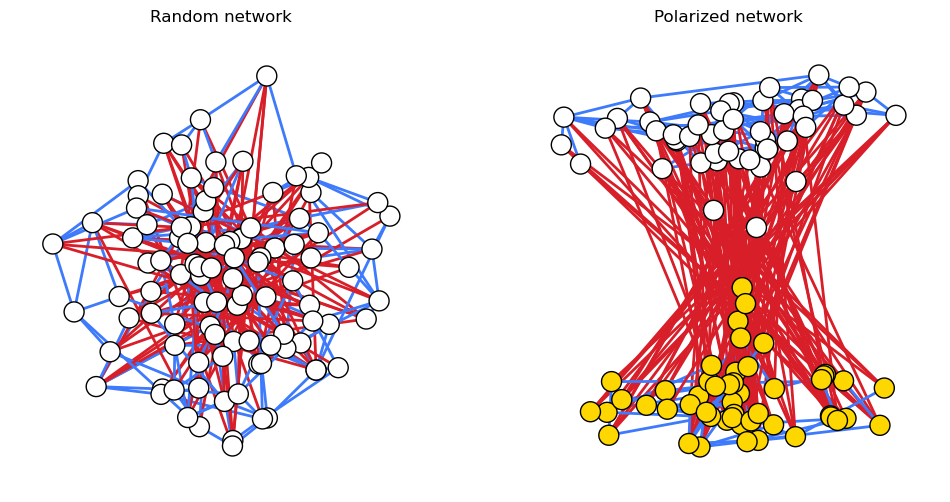

In [3]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# Random network ---------------------------------------------------------------------
N = 100
G_random = G = ig.Graph.Erdos_Renyi(N, p=.05, directed=False)
G.es["weight"] = np.where(RNG.random(G.ecount()) <= .5, 1, -1)
L = ig.Layout(signed_embedding(G))

ax = axes[0]
ax.set_title("Random network")
_ = ig.plot(G, target=ax, layout=L, edge_color=get_edge_colors(G))

# Polarized network ------------------------------------------------------------------
G_polarized = G = ig.Graph.Erdos_Renyi(N, p=.05, directed=False)
G.vs["group"] = np.repeat([0, 1], N//2)
G.es["weight"] = 1
G.es.select(
    _between=(
        G.vs.select(group=0),
        G.vs.select(group=1)
    )
)["weight"] = -1
L = ig.Layout(signed_embedding(G))

ax = axes[1]
ax.set_title("Polarized network")

vcolors = np.repeat(["white", "gold"], 50)
_ = ig.plot(G, target=ax, layout=L, vertex_color=vcolors, edge_color=get_edge_colors(G))

Note that in both cases we computed node layout for visualization using just the network
adjacency structure + edge signs, that is, especially in the second case we did not
use the information on the groups we used to generate the network structure.

However, we were somehow able to derive embedding that revealed this clustered
polarized structure by itself. How?

This is what structural balance theory is about. We will not be able to get exactly
to the point where we are ready to derive a smart embedding like the one above,
but we will at least understand some milestone ideas along this road.

### Structural balance - definition

* A signed graph is structurally balanced when it can be divided into two groups
  such that positive ties are only within groups and negative between them.

### Structure theorem

* A signed graph is structurally balanced if and only if all its cycles are positive,
  that is, products of their edge signs are positive.

### QUESTION

The two graphs we generated so far were based on Erdos-Renyi random graph model.
Should we expect them to have a lot or few cycles?

## Detecting structural balance

So it seems it should be easy to check whether a given graph is balanced or not.
It is enough to enumerate all cycles, check their signs, and that is it.

Okay, so let us try to do this.

Unfortunately, `igraph` does not implement any method for direct enumeration
of cycles, so we have to do this ourselves.

### PROBLEM

Implement a cycle enumerating function according to the following specification:

**HINT.**

Use `.get_all_simple_paths()` and `.neighbors()` methods.

In [4]:
def enumerate_cycles(
    graph: ig.Graph,
    vid: int,
    *,
    cutoff: int = 4,
) -> list[tuple[int, ...]]:
    """Enumerate all cycles including node given ``vid`` (vertex id).

    Parameters
    ----------
    graph
        Undirected graph to analyze.
    vid
        Integer id of the focal vertex.
    cutoff
        The maximum path length to consider.

    Returns
    -------
    cycles
        List of all cycles as tuples of integers corresponding to vertex ids
        and starting and ending with ``vid``.
    """
    cycles = []
    neighbors = graph.neighbors(vid)
    for nid in neighbors:
        paths = graph.get_all_simple_paths(vid, nid, cutoff=cutoff)
        paths = [(*p, vid) for p in paths if len(p) > 2]
        cycles.extend(paths)
    return cycles

In [5]:
from typing import Any
from tqdm.auto import tqdm


def get_cycle_edges(graph: ig.Graph, cycle: tuple[int, ...]) -> ig.EdgeSeq:
    """Get edges from a vertex representation of a cycle."""
    eids = []
    for source, target in zip(cycle[:-1], cycle[1:], strict=False):
        eids.extend(graph.es.select(_from=source, _to=target).indices)
    edges = ig.EdgeSeq(graph, eids)
    return edges

def cycle_sign(graph: ig.Graph, cycle: tuple[int, ...], attr: str = "weight") -> int:
    """Compute sign of an edge ``cycle``."""
    return np.prod(get_cycle_edges(graph, cycle)[attr])

def cycle_signs_distribution(
    graph: ig.Graph,
    progress: bool = False,
    **kwargs: Any
) -> tuple[int, int]:
    """Calculate frequency distribution of cycle signs.

    Parameters
    ----------
    graph
        Graph object (undirected).
    progress
        Should progress bar be displayed.
    **kwargs
        Optional keyword arguments passed to :func:`enumerate_cycles`.

    Returns
    -------
    pos, neg
        Frequencies of positive and negative cycles.
    """
    pos = neg = 0
    for vid in tqdm(graph.vs.indices, disable=not progress):
        for cycle in enumerate_cycles(graph, vid, **kwargs):
            if cycle_sign(graph, cycle) < 0:
                neg += 1
            else:
                pos += 1
    return pos, neg

/home/sztal/miniconda3/envs/sztal/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Ok, now after a bit of software engineering we are ready to study cycles in our graphs.
First, let us run approximate calculations limited to cycles of order $5$
(note the `cutoff` argument in `enumerate_cycles` function).

So what we do now is simple. We enumerate all cycles in a graph and check whether
the structure theorem holds.

In [6]:
cycle_signs_distribution(G_random, progress=True)

100%|██████████| 100/100 [00:00<00:00, 690.83it/s]


(932, 1064)

In [7]:
cycle_signs_distribution(G_polarized, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 398.94it/s]


(4046, 0)

This seems to work very well. Clearly the distribution of signs is approximately
uniform in the random case, which seems to make sense as in this case there is no
polarized structure, so any cycle should be equally likely to be positive or negative.

On the other hand, in the perfectly polarized case where we planted the clear signed
community structure ourselves, we confirm that there are no negative cycles.

This is nice, but in probably in practice we hardly ever find networks with such 
clear-cut structure. So it would be nice to have a more finely-grained measure of
structural balance that will tell us something about how close a given network is
to being perfectly balanced.

This leads to a very natural notion of the **degree-of-balance** (DoB):
$$
B(G) = \frac{\mu_+}{\mu_+ + \mu_i}
$$
which is simply the fraction of positive cycles. If approaches $1$ then a network
is close to being balanced. For networks with random polarization structure it
should fluctuate near $0.5$.

Now, to check whether this approach makes sense we will study how DoB changes
in our polarized graph as we introduce more and more **frustrated edges**,
that is, flip signs of increasing fractions of edges leading to some in-group
ties being positive and out-group ties negative.

In [8]:
ngrid = 20
P_flip = np.linspace(0, 1, ngrid)
DoB = np.empty_like(P_flip)

for i, p in tqdm(enumerate(P_flip), total=ngrid):
    G = G_polarized.copy()
    W = np.array(G.es["weight"])
    mask = RNG.random(W.size) <= p
    W[mask] *= -1
    G.es["weight"] = W
    pos, neg = cycle_signs_distribution(G, progress=False)
    dob = pos / (pos + neg)
    DoB[i] = dob

100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


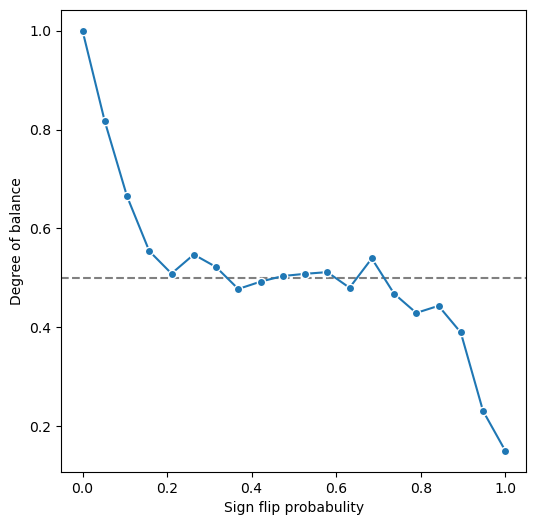

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.axhline(.5, ls="--", color="gray")
ax.set_xlabel("Sign flip probabulity")
ax.set_ylabel("Degree of balance")
_ = ax.plot(P_flip, DoB, marker="o", markeredgecolor="white")

Ok, so it seems that we have a good measure of partial balance.
However, there is another more fundamental problem. Enumerating cycles
is very expensive in larger graphs. Here we actually considered only an approximation
based on considering cycles of lengths up to $5$, not all of them.

For graphs significantly larger than $100$ nodes even this approximation could be
hard to compute in practice.

In [10]:
%%time
cycle_signs_distribution(G_polarized, cutoff=4, progress=True)

100%|██████████| 100/100 [00:00<00:00, 409.90it/s]

CPU times: user 246 ms, sys: 0 ns, total: 246 ms
Wall time: 245 ms


(4046, 0)

In [11]:
%%time
cycle_signs_distribution(G_polarized, cutoff=5, progress=True)

100%|██████████| 100/100 [00:01<00:00, 73.62it/s]

CPU times: user 1.36 s, sys: 3.99 ms, total: 1.36 s
Wall time: 1.36 s


(19898, 0)

In [12]:
%%time
cycle_signs_distribution(G_polarized, cutoff=6, progress=True)

100%|██████████| 100/100 [00:07<00:00, 13.66it/s]

CPU times: user 7.32 s, sys: 6.42 ms, total: 7.33 s
Wall time: 7.32 s


(94938, 0)

## Approximating paths with walks

Paths and cycles are hard to enumerate and count because they are constrained, so they
not contain any node more than once (except for the starting node in a cycle).
Walks and closed walks are similar but weaker notions which allow for visiting the same
node more than once. And this makes them much easier to compute.

In order to appreciate that we need to resort to the representation of a graph as
an adjacency matrix.

Let us first consider this problem in the simple case of unsigned and undirected graphs.

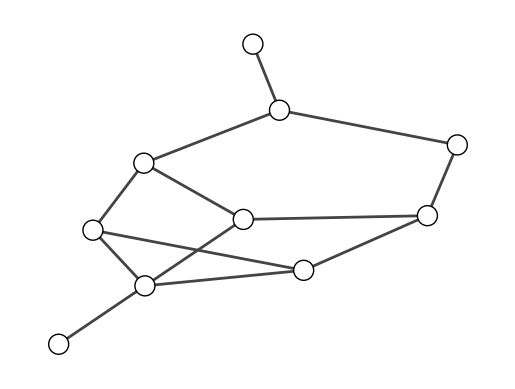

In [13]:
random.seed(304)

G = ig.Graph.Erdos_Renyi(10, p=.3, directed=False)
ig.plot(G)

And here is the adjacency matrix of the above graph.
It is simply a square matrix consisting of $0$'s and $1$'s.

In [14]:
A = G.get_adjacency_sparse().toarray()
A

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 0]])

Now, let us consider the second power of $A$, which we can take since $A$ is square,
so it can multiply with itself:
$$
A^2 = AA
$$

According to the rules of matrix-matrix multiplication the $ij$'th element of $A^2$
is given by the dot product of the $i$'th row and $j$'th column of $A$
$$
A^2_{ij}= A_{i\cdot} \cdot A_{\cdot{}j} = \sum_{k=1}^n a_{ik}a_{kj}
$$

More visually, the above computation looks like this:

$$
\begin{array}{c|ccccc}
    k & 1 & 2 & 3 & \cdots & n-1 & n \\
    \hline
    a_{ik} & 0 & 1 & 0 & \cdots & 0 & 1 \\
    a_{kj} & 1 & 1 & 0 & \cdots & 1 & 1 \\
    \hline
    a_{ik}a_{kj} & 0 & 1 & 0 & \cdots & 0 & 1 
\end{array}
$$

Now, the question is what is the meaning of $a_{ik}a_{kj}$ in this context?
Since it is a product of two binary variables it is a binary variable itself.
So there are only two options:

$$
a_{ik}a_{kj} = \begin{cases}
    1,\quad\text{if $k$ is connected to both $i$ and $j$},\\
    0,\quad\text{otherwise}
\end{cases}
$$

In other words, $a_{ik}{kj}$ is an indicator variable telling us whether $k$ is
a shared neighbor of both $i$ and $k$j. And since an entry $A^2_{ij}$ is a sum over
such indicators for all $k$'s then it must be that $A^2_{ij}$ is equal to the number
of common neighbors shared by $i$ and $j$. Simple.

Moreover, each common neighbor defines one walk of length $2$ connecting $i$ and $j$.
So equivalently $A^2_{ij}$ is equal to the number of 2-walks between $i$ and $j$.

And this reasoning can be extended to arbitrary powers $A^k$ using mathematical
induction. As a result, we now know that the powers $A^k$ count the number of walks
of length $k$ between all pairs $(i, j)$.

Last but not least, the diagonal elements of $A^k$ specifies the numbers of closed
walks starting and ending at a given node $i$, so the number of closed walks of length
$n$ is given by the trace of the corresponding matrix:

$$
\text{tr}A^k = \sum_{i=1}^n A^k_{ii}
$$

### Signed walks

But what happens when we allow for negative ties? Let us consider the table from
the previous section once again, but this time with some negative edges.

$$
\begin{array}{c|ccccc}
    k & 1 & 2 & 3 & \cdots & n-1 & n \\
    \hline
    a_{ik} & 0 & -1 & 0 & \cdots & 0 & 1 \\
    a_{kj} & -1 & 1 & 0 & \cdots & -1 & 1 \\
    \hline
    a_{ik}a_{kj} & 0 & -1 & 0 & \cdots & 0 & 1 
\end{array}
$$

Clearly, now $a_{ik}a_{kj}$ has a slightly different interpretation. Its absolute
value is still a binary indicator that tells us whether $i$ and $j$ are connected
through $k$, but additionally the sign of $a_{ik}a_{kj}$ specifies whether the product
over the edge sings in the 2-walk through $k$ is positive or not. Hence, the sum over
$a_{ik}a_{kj}$ for all $k$'s gives the difference between the number positive and 
negative 2-walks between $i$ and $j$.

Finally, after going through the similar arguments as previously, we end up with a
result that $A^k_{ij}$'s give the differences between the numbers of positive and 
negative walks of length $k$, and more specifically $A^k_{ii}$'s give the difference
between the numbers of positive and negative closed walks including $i$.

And this is a starting point for defining walk-based DoB measures like the ones
in [this article](https://www.nature.com/articles/s42005-023-01467-8).
To get a proper framework much more technical details need to be handled, of course,
but the above considerations are a fundamental starting point.

Now, instead of discussing further, we turn to an analysis of an empirical dataset
that will allow us to measure the increasing polarization within the U.S. Congress.

## U.S. Congress analysis using `msb` package

Now we will use `msb` package implementing walk-based methods from 
[this article](https://www.nature.com/articles/s42005-023-01467-8)
to study polarization in the U.S. Senate.

> Talaga, S., Stella, M., Swanson, T. J., & Teixeira, A. S. (2023). 
> Polarization and multiscale structural balance in signed networks. 
> Communications Physics, 6(1), 349.

We will focus on so-called co-sponsorship networks 
(one for each congress between 93rd and 114th congress).
Co-sponsorship is a semi-institutionalized mechanism in the U.S. Congress through
which different senators and representatives may indicate their official support
for a given legislative proposal.

And co-sponsorship networks are signed networks in which a positive tie between
a given pair indicates that the two senators have a statistically significant tendency
to co-sponsor the same bills and negative ties means that they have a statistically
significant tendency not to sponsor the same bills. No tie means that their pattern
of co-sponsorship looks random.

In [15]:
# IF NECESSARY INSTALL `msb` PACKAGE FROM GITHUB
# !pip install "git+ssh://git@github.com/sztal/msb.git"

We will first make a sanity check and see whether the walk-based methods implemented
in the `msb` package give sensible results for our two toy graphs. This will also
give us an opportunity to learn how it works.

In [20]:
from msb import Balance

## DoB in the random graph
Balance(G_random).balance()

0.6836922868391861

In [21]:
## DoB in the polarized graph
Balance(G_polarized).balance()

1.000000000000003

Ok, it looks reasonable. But:

### QUESTION

Do you have any idea why the DoB in the random case is still relatively large,
that is, low but markedly larger than $0.50$?

Answer to this question will reveal one of the "costs" one has to pay by using
walk-based approximations.

### U.S. Senate analysis

In [118]:
## LOAD DATA
congresses = np.arange(93, 115)

networks = [
    ig.Graph.Read_GraphMLz(f"data/S{congress}.graphml.gz")
    for congress in congresses
]

In [115]:
%%time

## CALCULATE DOBs using 'msb' AND BASED ON SHORT CYCLES
dob_walks  = []
dob_cycles = []

for network in tqdm(networks):
    dob_w = Balance(network).balance()
    pos, neg = cycle_signs_distribution(network, cutoff=2)
    dob_c = pos / (pos + neg)

    dob_walks.append(dob_w)
    dob_cycles.append(dob_c)

dob_walks  = np.array(dob_walks)
dob_cycles = np.array(dob_cycles)

100%|██████████| 22/22 [08:13<00:00, 22.41s/it]


Text(0.5, 0, 'Congress')

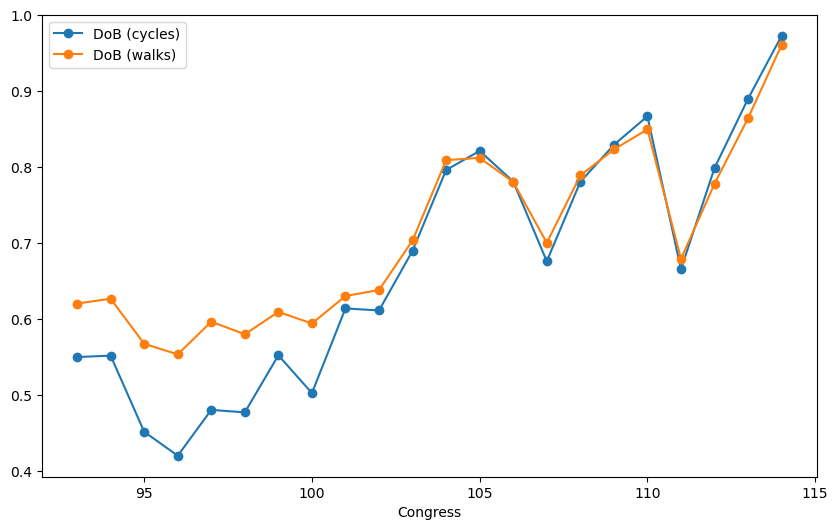

In [124]:
## Visualize
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(congresses, dob_cycles, marker="o", label="DoB (cycles)")
ax.plot(congresses, dob_walks, marker="o", label="DoB (walks)")
ax.legend()
ax.set_xlabel("Congress")